In [45]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#obtenir une dataset en utilisant tf 
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256,256),
    batch_size=32)

Found 2152 files belonging to 3 classes.


In [3]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
#nombre de batch
len(dataset)

68

In [5]:
#dataset.take(1) c'est à dire se placer dans le batch num 1
#label_batch c'est la classe de chaque photo
#image_batch c'est l'ensemble de 32 photos
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 2 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0]


## Visualisation:

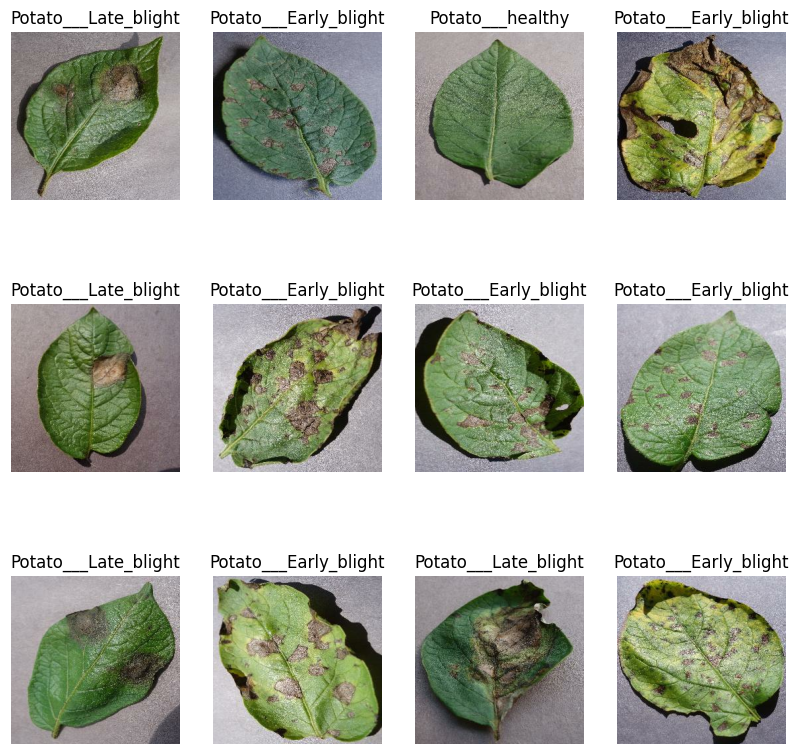

In [6]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch.numpy()[i]])

In [7]:
len(dataset)

68

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
#on va donc considérer les 54 premiers batchs pour le training dataset
train_ds=dataset.take(54)

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)

In [12]:
len(test_ds)

8

In [13]:
# create a function pour le travail ci-dessus:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True,shuffle_size=10000):
        ds_size=len(ds)
        if shuffle:
            ds=ds.shuffle(shuffle_size,seed=12)
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        test_size=int(test_split*ds_size)
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

## Preprocessing:

In [18]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Model bulding:

In [21]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
])
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [23]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [24]:
EPOCHS=50
history=model.fit(train_ds,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 16s 174ms/step - loss: 0.8765 - accuracy: 0.5388 - val_loss: 0.7406 - val_accuracy: 0.6510
Epoch 2/50
54/54 [==============================] - 9s 175ms/step - loss: 0.6516 - accuracy: 0.7164 - val_loss: 0.4540 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 9s 160ms/step - loss: 0.4181 - accuracy: 0.8223 - val_loss: 0.3296 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 9s 159ms/step - loss: 0.3810 - accuracy: 0.8507 - val_loss: 0.3311 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 9s 159ms/step - loss: 0.2350 - accuracy: 0.9034 - val_loss: 0.3351 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 8s 156ms/step - loss: 0.2218 - accuracy: 0.9213 - val_loss: 0.2000 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 8s 153ms/step - loss: 0.2015 - accuracy: 0.9230 - val_loss: 0.1520 - val_accuracy: 0.9583
Epoch

In [25]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 1s 26ms/step - loss: 0.1392 - accuracy: 0.9570


In [26]:
scores

[0.13924816250801086, 0.95703125]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history['accuracy']

[0.5387731194496155,
 0.7164351940155029,
 0.8223379850387573,
 0.8506944179534912,
 0.9033564925193787,
 0.9212962985038757,
 0.9230324029922485,
 0.9467592835426331,
 0.9276620149612427,
 0.9282407164573669,
 0.9565972089767456,
 0.9490740895271301,
 0.9594907164573669,
 0.9733796119689941,
 0.9583333134651184,
 0.9756944179534912,
 0.9762731194496155,
 0.984375,
 0.9791666865348816,
 0.9832175970077515,
 0.9814814925193787,
 0.9832175970077515,
 0.9554398059844971,
 0.9762731194496155,
 0.9791666865348816,
 0.9861111044883728,
 0.9745370149612427,
 0.9861111044883728,
 0.9872685074806213,
 0.9849537014961243,
 0.9878472089767456,
 0.9895833134651184,
 0.9826388955116272,
 0.9924768805503845,
 0.9820601940155029,
 0.9855324029922485,
 0.9832175970077515,
 0.9930555820465088,
 0.9895833134651184,
 0.9872685074806213,
 0.9866898059844971,
 0.9890046119689941,
 0.9918981194496155,
 0.9924768805503845,
 0.9942129850387573,
 0.9942129850387573,
 0.9930555820465088,
 0.9537037014961243,
 0

In [31]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

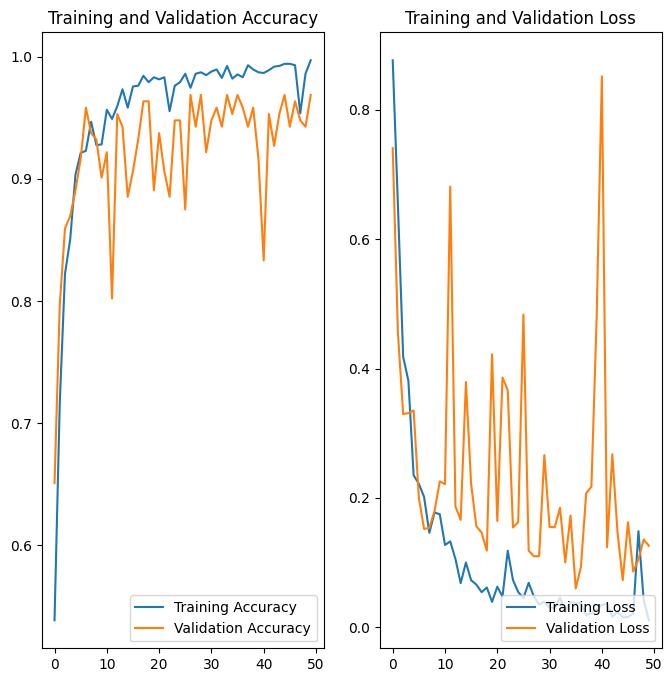

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')


First image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 42ms/step
Potato___Early_blight


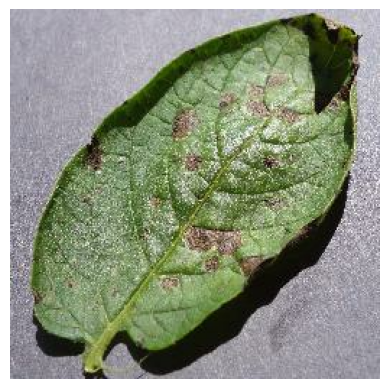

In [49]:
for images_batch , labels_batch in test_ds.take(1):
    first_image=(images_batch[0].numpy().astype('uint8'))
    first_label=(class_names[labels_batch[0]])
    plt.axis('off')
    print('First image to predict')
    plt.imshow(first_image)
    print("Actual label:",first_label)
    batch_prediction=model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [55]:
batch_prediction[0]

array([1.0000000e+00, 3.2692434e-08, 1.3562791e-22], dtype=float32)

In [48]:
np.argmax(batch_prediction[0])

0

In [53]:
def predict (model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) # create a batch
    prediction=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence =round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

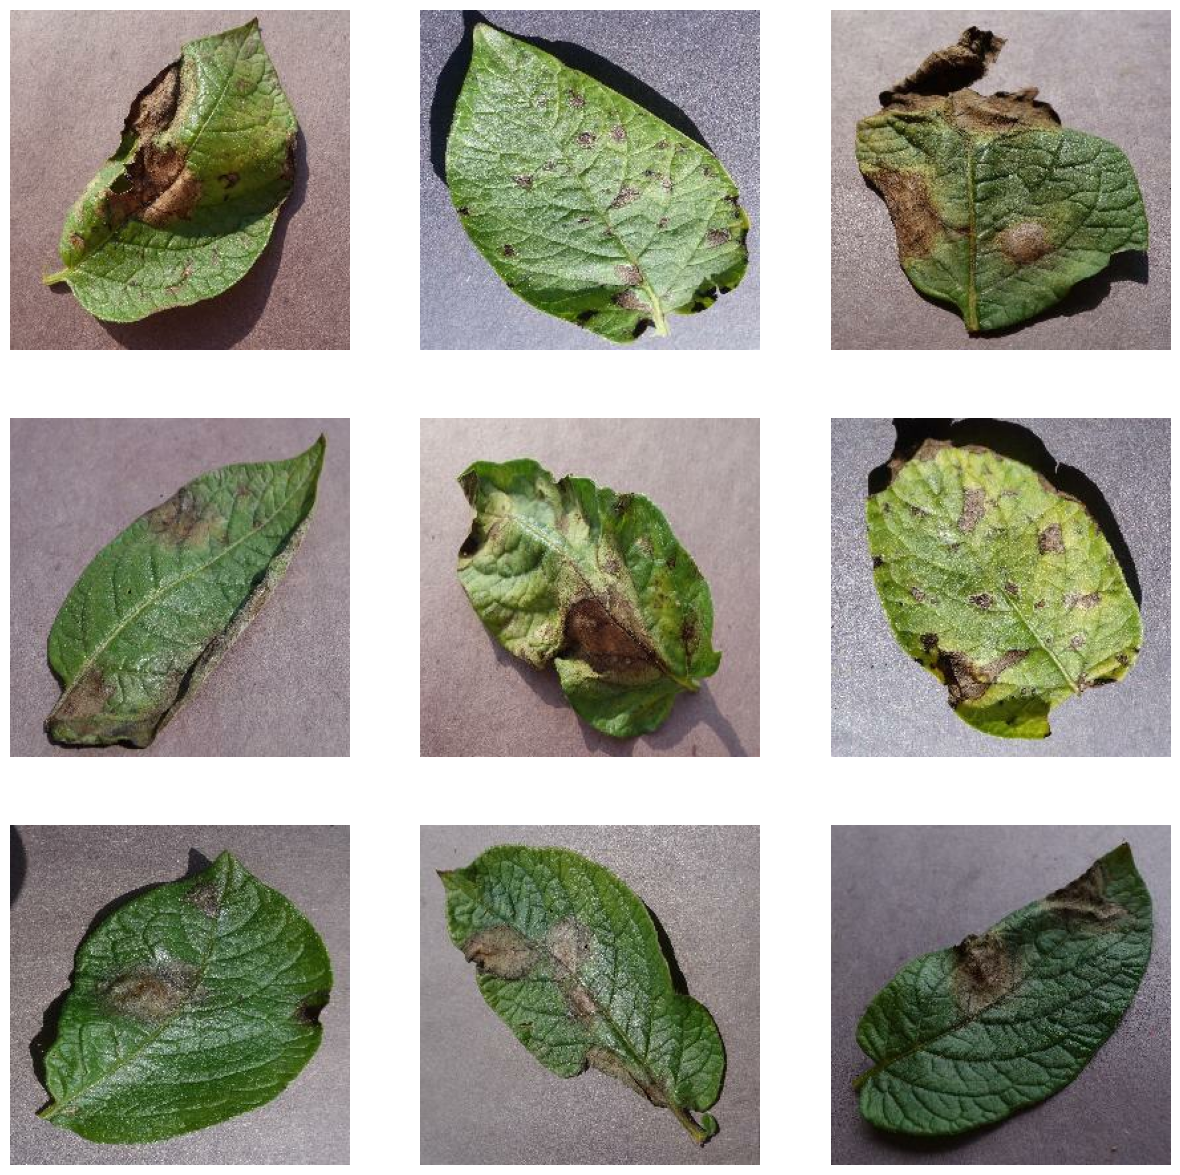

In [58]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n confidence: {confidence}%")
        plt.axis('off')